# Science Case Cadence

The purpose of this notebook is to explore the time domain parameters of survey design for the proposed science cases.

The configuration of each case includes the specification of the numbers of visits to each pointing required, together with the desired interval between visits and the total duration of repeated visits.  

In [1]:
from os import path, getcwd
from sys import path as pythonpath
pythonpath.append(path.join(getcwd(), '..'))
import config_utils
import survey_footprints
import regions
import healpy as hp
from mw_plot import MWSkyMap, MWSkyMapBokeh
from astropy_healpix import HEALPix
from astropy import units as u
from astropy.coordinates import Galactic, TETE, SkyCoord, ICRS
from astropy.table import Table, Column
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json
from os import path
%matplotlib inline


# Configure path to local repository
root_dir = '/Users/rstreet/software/rgps'

## Set up

In [2]:
sim_config = config_utils.read_config(path.join(getcwd(), '..', 'config', 'sim_config.json'))

In [3]:
science_cases = config_utils.read_config(path.join(root_dir, 'config', 'rgps_science_cases.json'))

In [4]:
time_domain_science = {author: info for author, info in science_cases.items() if info['time_domain'] and info['ready_for_use']}

## Requested cadence parameters

Science cases can defined multiple sky regions of interest for each filter, and request that each of these be observed in different filters with different cadence parameters.  
To visualize the range of cadences requested, we compile a dataset of the regions for all science cases in all filters. 

In [8]:
author_list = [key for key in time_domain_science.keys()]
author_list.sort()

labels = []
nvisits = []
intervals = []
durations = []
topics = []
for author in author_list:
    params = time_domain_science[author]
    
    topics.append(', '.join(params['topics']))
    labels.append(author + ': ' + params['code'])

    got_region = False
    for optic in sim_config['OPTICAL_COMPONENTS']:
        # While in principle each region can have its own cadence parameters, in practise all science cases 
        # seem to have requested the same parameters for each region.  We collapse those into a single entry for plotting
        if optic in params.keys() and len(params[optic]) > 0 and not got_region:

            # If a range of visit intervals are requested take an average
            if len(params[optic][0]['visit_interval']) > 1: 
                intervals.append(np.array(params[optic][0]['visit_interval']).mean())
            else:
                intervals.append(params[optic][0]['visit_interval'][0])
            nvisits.append(params[optic][0]['nvisits'])
            durations.append(params[optic][0]['duration'])
            got_region = True

td_params = Table([
            Column(name='labels', data=labels), 
            Column(name='topics', data=topics),
            Column(name='nvisits', data=nvisits),
            Column(name='intervals', data=intervals), 
            Column(name='duration', data=durations)
        ])
    
td_params

labels,topics,nvisits,intervals,duration
str17,str16,int64,float64,float64
Bahramian: SP27,X-ray binaries,90,24.0,90.0
Benecchi: WP05,KBO,6,2920.0,730.0
Bonito: SP48,"YSO, SFR",96,0.25,1.0
DAmmando: SP12,AGN,40,96.0,160.0
Daylan: SP26,Microlensing,192,0.25,2.0
Freeman: SP13,RR Lyrae,30,288.0,365.0
Kupfer: WP03,Compact binaries,60,0.13,0.4
Lian: SP09,Microlensing,10,73.0,720.0
Morihana1: SP22,CV,20,0.5,0.21


We also want to compare these science cases with the survey strategy for time domain fields.  

In [46]:
survey_strategy = config_utils.read_config(path.join(root_dir, 'config', 'rgps_survey_definitions.json'))

For the time domain fields, build arrays of the equivalent time cadence parameters for comparision.

In [55]:
labels = []
nvisits = []
min_intervals = []
max_intervals = []
filters = []
durations = []

for optic in sim_config['OPTICAL_COMPONENTS']:
    if optic in survey_strategy['time_domain'].keys() and len(survey_strategy['time_domain'][optic]) > 0:

        # Some fields have fractional visits in some filters - this indicates that a single epoch of multi-band observations will be 
        # obtained.  Since this is not a time cadence, these entries are excluded
        for r in survey_strategy['time_domain'][optic]:
            if r['nvisits'] >= 1.0:
                labels.append(r['name'])
                filters.append(optic)
                nvisits.append(r['nvisits']) 
                intervals.append(r['visit_interval']) 
                durations.append(r['duration'])
                if len(r['visit_interval']) > 1:
                    int_values = [x for x in r['visit_interval'] if x > 0]
                    min_intervals.append(np.array(int_values).min())
                    max_intervals.append(np.array(int_values).max())
                else:
                    min_intervals.append(r['visit_interval'][0])
                    max_intervals.append(r['visit_interval'][0])

survey_cadence = Table([
    Column(name='label', data=labels), 
    Column(name='filter', data=filters), 
    Column(name='nvisits', data=nvisits), 
    Column(name='min_intervals', data=min_intervals), 
    Column(name='max_intervals', data=max_intervals), 
    Column(name='duration', data=durations)
])

survey_cadence

label,filter,nvisits,min_intervals,max_intervals,duration
str22,str4,float64,float64,float64,float64
TDS_Galactic_Center_Q4,F129,10.0,240.0,1512.0,61.0
TDS_Galactic_Center_Q1,F129,10.0,240.0,1512.0,61.0
TDS_W43,F184,43.0,0.18,0.18,0.335
TDS_Galactic_Center_Q4,F213,60.0,0.18,1512.0,63.0
TDS_Galactic_Center_Q1,F213,60.0,0.18,1512.0,63.0
TDS_NGC6334_6357,F213,43.0,0.18,0.18,0.35
TDS_Carina,F213,43.0,0.18,0.18,0.335
TDS_Serpens_W40,F213,8.0,4.0,70.0,2.92


In [60]:
PLOT_COLORS = {
    "X-ray binaries": "#5f038c",
    "KBO": "#3303ab",
    "YSO, SFR": "#0344a6",
    "AGN": "#04b8ac",
    "Microlensing": "#058c01",
    "RR Lyrae": "#ab6902",
    "Compact binaries": "#7a0701",
    "CV": "#7d039c",
    "YSO, Exoplanets": "#080f17",
    "GW": "#2c0182",
    "Galactic Center": "#000000"
  }

SURVEY_COLORS = {
    'F129': '#1633d9', 
    'F184': '#9216d9', 
    'F213': '#890023'
}

/var/folders/1d/5hlyfsgd0kl_nd815xmp9cv00000gn/T/ipykernel_76059/4033749662.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels, fontsize=18)
/var/folders/1d/5hlyfsgd0kl_nd815xmp9cv00000gn/T/ipykernel_76059/4033749662.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticklabels, fontsize=18)


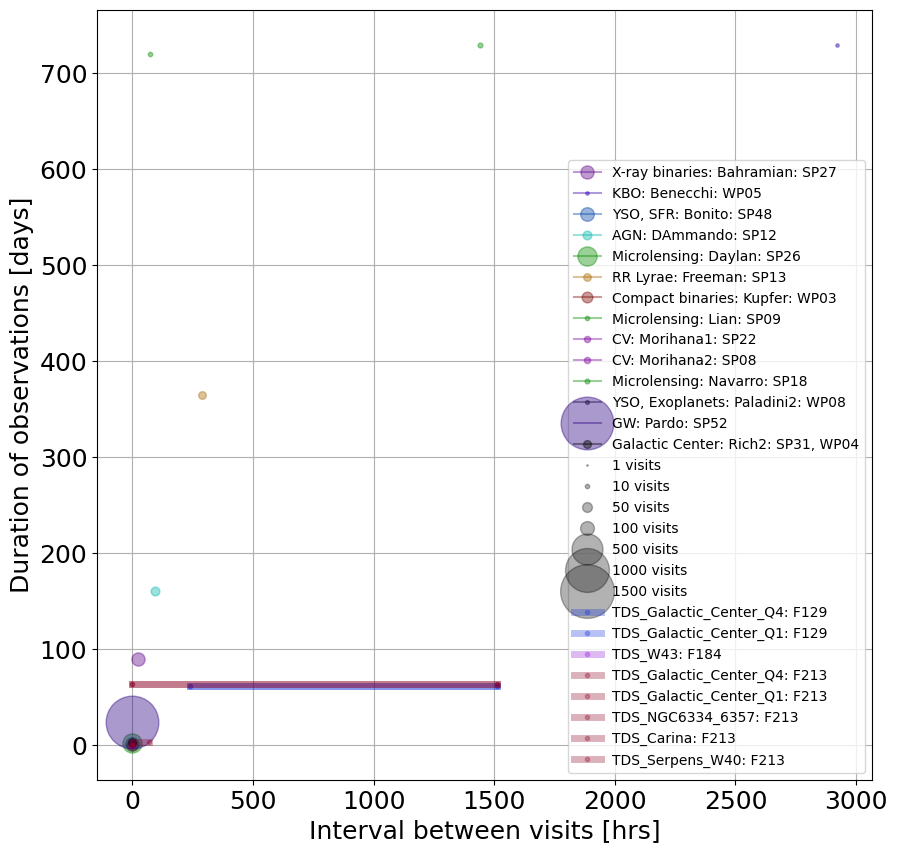

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10)) 

# Scale factor for point sizes, representing the number of visits
scale_factor = 1.0 

# Plot separately to assign defined plot colors by topic
for row in td_params:
    ax.plot(
        row['intervals'], 
        row['duration'], 
        marker='o',
        markersize=np.sqrt(row['nvisits'])*scale_factor, 
        c=PLOT_COLORS[row['topics']], 
        alpha=0.4, 
        label=row['topics'] + ': ' + row['labels']
    ) 

# Build entries for pointsize legend, then append the entry for the wide-field survey shading; 
# order matters here
for entry in [1, 10, 50, 100, 500, 1000, 1500]:
    ax.plot([], [], c='k', alpha=0.3, markersize=np.sqrt(entry)*scale_factor, marker='o', ls='none', label=str(entry)+' visits')

# Plot bars to represent the time domain survey fields 
for row in survey_cadence: 
    ax.plot(
        [row['min_intervals'], row['max_intervals']], 
        [row['duration'], row['duration']], 
        marker='.', ls='-', lw='5', c=SURVEY_COLORS[row['filter']], 
        alpha=0.3,
        label=row['label'] + ': ' + row['filter']
    )

ax.set_xlabel('Interval between visits [hrs]', fontsize=18) 
ax.set_ylabel('Duration of observations [days]', fontsize=18)
ax.grid()
ax.legend()
xticklabels = ax.get_xticklabels()
ax.set_xticklabels(xticklabels, fontsize=18)
yticklabels = ax.get_yticklabels()
ax.set_yticklabels(yticklabels, fontsize=18)

plt.savefig(path.join(root_dir, 'time_domain_science', 'TDA_req_vs_survey_cadence.png'))

Zooming in on the short duration / high cadence area...

/var/folders/1d/5hlyfsgd0kl_nd815xmp9cv00000gn/T/ipykernel_76059/304782317.py:47: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim([xmin, xmax])
/var/folders/1d/5hlyfsgd0kl_nd815xmp9cv00000gn/T/ipykernel_76059/304782317.py:48: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim([ymin, ymax])
/var/folders/1d/5hlyfsgd0kl_nd815xmp9cv00000gn/T/ipykernel_76059/304782317.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels, fontsize=18)
/var/folders/1d/5hlyfsgd0kl_nd815xmp9cv00000gn/T/ipykernel_76059/304782317.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticklabels, fontsize=18)


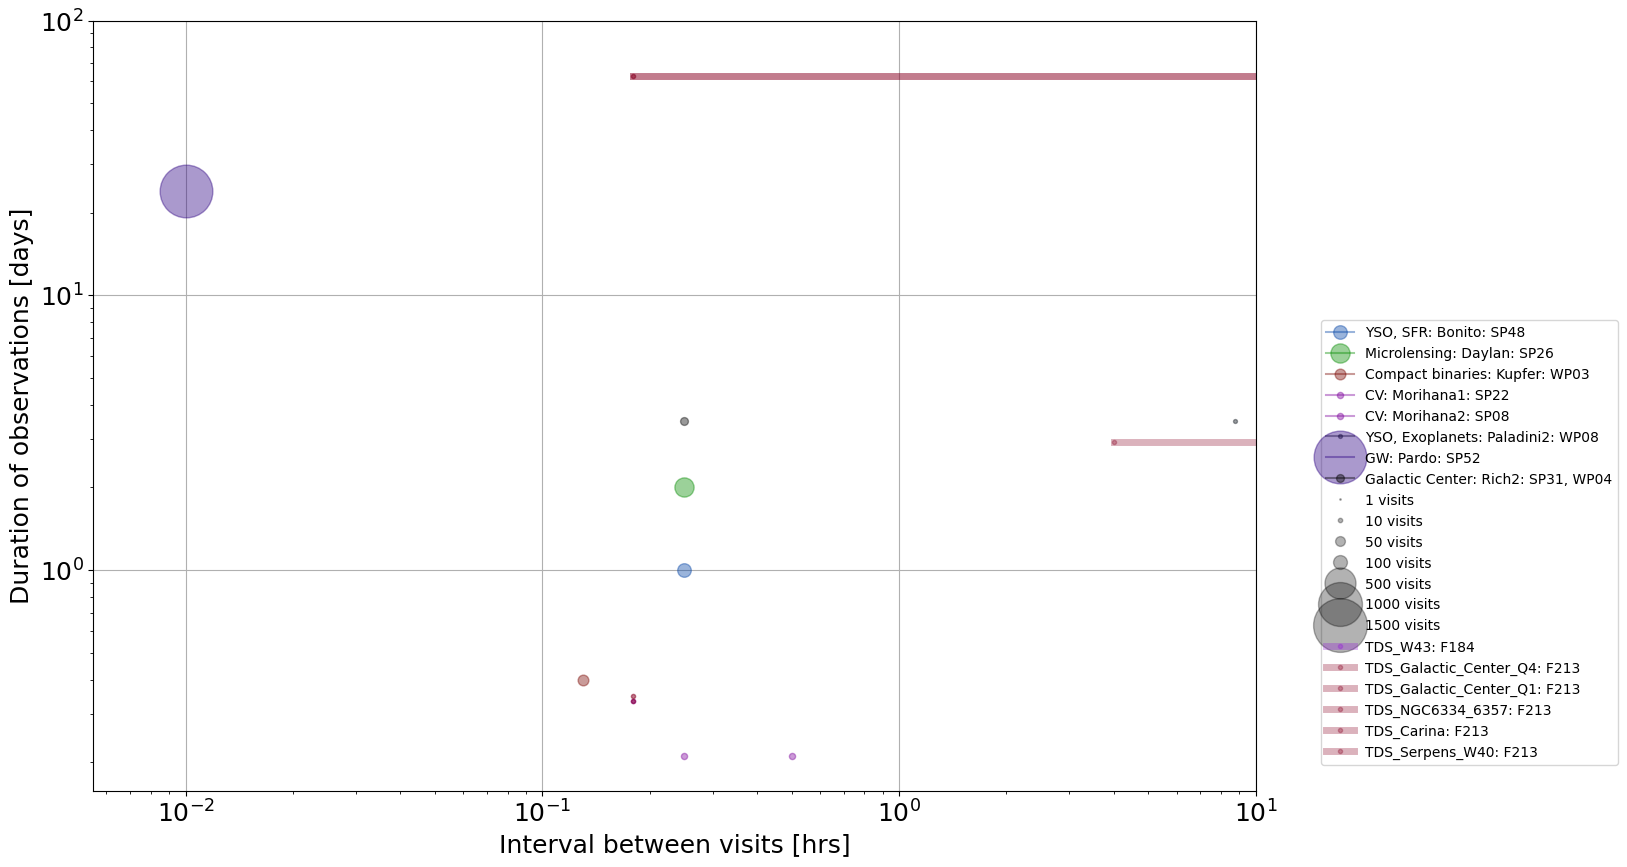

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10)) 

# Scale factor for point sizes, representing the number of visits
scale_factor = 1.0 

# Zoom 
xmin = 0.0
xmax = 10.0
ymin = 0.0
ymax = 100.0

# Plot separately to assign defined plot colors by topic
for row in td_params:
    if row['intervals'] < xmax and row['duration'] < ymax:
        ax.plot(
            row['intervals'], 
            row['duration'], 
            marker='o',
            markersize=np.sqrt(row['nvisits'])*scale_factor, 
            c=PLOT_COLORS[row['topics']], 
            alpha=0.4, 
            label=row['topics'] + ': ' + row['labels']
        ) 

# Build entries for pointsize legend, then append the entry for the wide-field survey shading; 
# order matters here
for entry in [1, 10, 50, 100, 500, 1000, 1500]:
    ax.plot([], [], c='k', alpha=0.3, markersize=np.sqrt(entry)*scale_factor, marker='o', ls='none', label=str(entry)+' visits')

# Plot bars to represent the time domain survey fields 
for row in survey_cadence: 
    if row['min_intervals'] < xmax and row['duration'] < ymax:
        ax.plot(
            [row['min_intervals'], row['max_intervals']], 
            [row['duration'], row['duration']], 
            marker='.', ls='-', lw='5', c=SURVEY_COLORS[row['filter']], 
            alpha=0.3,
            label=row['label'] + ': ' + row['filter']
        )

ax.set_xscale('log') 
ax.set_yscale('log')
ax.set_xlabel('Interval between visits [hrs]', fontsize=18) 
ax.set_ylabel('Duration of observations [days]', fontsize=18)
ax.grid()

ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

ax.legend(bbox_to_anchor=(1.05, 0.62))

xticklabels = ax.get_xticklabels()
ax.set_xticklabels(xticklabels, fontsize=18)
yticklabels = ax.get_yticklabels()
ax.set_yticklabels(yticklabels, fontsize=18)

plt.savefig(path.join(root_dir, 'time_domain_science', 'TDA_req_vs_survey_cadence_high_cadence.png'))